In [ ]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import random
import math
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
from torch.amp import autocast, GradScaler

# Data Preprocessing
#### load data

In [ ]:
from datasets import load_dataset

ds = load_dataset("sentence-transformers/parallel-sentences-europarl", "en-es")

print(ds)
print(ds['train'][0])
dataset = ds['train']

DatasetDict({
    train: Dataset({
        features: ['english', 'non_english'],
        num_rows: 1966848
    })
})
{'english': 'Resumption of the session', 'non_english': 'Reanudación del período de sesiones'}


In [ ]:
subset = dataset.shuffle(seed=42).select(range(50000))
subset = subset.to_pandas()
subset.head()

,english,non_english
0,According to the United Nations Food and Agric...,Según la Organización de las Naciones Unidas p...
1,"Once again, we see the conflict between indust...",Una vez más vemos surgir el conflicto entre la...
2,All that has allowed us to understand one anot...,Todo esto ha hecho posible que nos conozcamos ...
3,The EU uses those expectations to demand refor...,La Unión Europea utiliza estas expectativas pa...
4,The relevant paragraphs have been amended and ...,Se han modificado los párrafos pertinentes y y...


In [ ]:
esp = subset['non_english'].to_list()
esp_sizes = [len(i.split()) for i in esp]
eng = subset['english'].to_list()
eng_sizes = [len(i.split()) for i in eng]

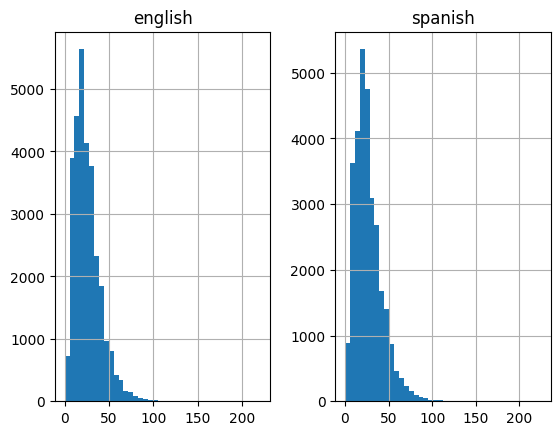

<Figure size 1200x800 with 0 Axes>

In [ ]:
length_df = pd.DataFrame({'english':eng_sizes, 'spanish':esp_sizes})
length_df.hist(bins = 40)
plt.figure(figsize = (12,8))
plt.show()

In [ ]:
percentile_95 = length_df.quantile(0.95)
print(percentile_95)

english    54.0
spanish    57.0
Name: 0.95, dtype: float64


In [ ]:
import unicodedata
import re

def unicode_to_ascii(s):
    normalized = unicodedata.normalize('NFD', s)
    return ''.join(c for c in normalized if unicodedata.category(c) != 'Mn')              # done to convert special chars in spanish to ascii

def process_text(text):
    text = unicode_to_ascii(text.lower().strip())
    text = re.sub(r'[^a-z?.!,¿]+', ' ', text)      # as character- ¿ belongs to spanish vocab
    text = re.sub(r"([?.!,¿])", r" \1 ", text)     # adds extra space before the punctuation to tokenize lateron 
    text = re.sub(r'[" "]+', " ", text)            # replaces multiple continuous white spaces with a single white space
    text = '<sos> ' + text + ' <eos>'
    return text                # start of sentence, end of sentence

In [ ]:
esp = [process_text(text) for text in esp]
eng = [process_text(text) for text in eng]
esp[0], eng[0]

('<sos> segun la organizacion de las naciones unidas para la agricultura y la alimentacion , la produccion de alimentos debe aumentar como minimo un para atender la creciente demanda de una poblacion mundial que se espera supere los millones de personas en .  <eos>',
 '<sos> according to the united nations food and agricultural organisation , food production must increase by at least to meet the growing demands of a world population which is expected to exceed billion by the year .  <eos>')

## Vocab creation
#### - same as previous notebook

In [ ]:
from collections import Counter

def get_vocab(text_list):
    all_words = [word for sentence in text_list for word in sentence.split()]

    word_counts = Counter(all_words)

    special_tokens = ['<pad>', '<unk>', '<sos>', '<eos>']
    vocab = {token: i for i, token in enumerate(special_tokens)}

    count = len(vocab)

    for word, _ in word_counts.most_common():          # .most_common() to get words in order of their frequency
        if word not in vocab:
            vocab[word] = count
            count+=1

    idx2word = {i: word for word, i in vocab.items()}

    return vocab, idx2word

In [ ]:
word2idx_esp, idx2word_esp = get_vocab(esp)
word2idx_eng, idx2word_eng = get_vocab(eng)
print(f"Spanish vocabulary size: {len(word2idx_esp)}")
print(f"English vocabulary size: {len(word2idx_eng)}")

Spanish vocabulary size: 28916
English vocabulary size: 19013


In [ ]:
unk_idx_eng = word2idx_eng['<unk>']
unk_idx_esp = word2idx_esp['<unk>']

esp_transformed = []
for sentence in esp:
    indices = []
    for word in sentence.split():
        indices.append(word2idx_esp.get(word, unk_idx_esp))
    esp_transformed.append(indices)

eng_transformed = []
for sentence in eng:
    indices = []
    for word in sentence.split():
        indices.append(word2idx_eng.get(word, unk_idx_eng))
    eng_transformed.append(indices)

In [ ]:
import torch

def pad_and_clip_sequences(sequences, max_len, padding_value):
    padded_sequences = []
    for seq in sequences:
        if len(seq) > max_len:
            clipped_seq = seq[:max_len]             #Clip the sequence
            padded_sequences.append(clipped_seq)
        else:
            padded_seq = seq + [padding_value] * (max_len - len(seq))       # Pad the sequence
            padded_sequences.append(padded_seq)
            
    return torch.tensor(padded_sequences, dtype=torch.long)

MAX_LENGTH = 57
PAD_IDX_ESP = word2idx_esp['<pad>'] 
PAD_IDX_ENG = word2idx_eng['<pad>'] 

# Apply padding and clipping
esp_tensor = pad_and_clip_sequences(esp_transformed, MAX_LENGTH, PAD_IDX_ESP).transpose(0, 1)
eng_tensor = pad_and_clip_sequences(eng_transformed, MAX_LENGTH, PAD_IDX_ENG).transpose(0, 1)

print("Spanish Tensor Shape:", esp_tensor.shape)
print(esp_tensor)

Spanish Tensor Shape: torch.Size([57, 30000])
tensor([[   2,    2,    2,  ...,    2,    2,    2],
        [ 462,   19,   59,  ...,    9,  806,    6],
        [   6,  104,   62,  ..., 1199,    8,  880],
        ...,
        [   0,    0,  509,  ...,    0,    0,   37],
        [   0,    0,    5,  ...,    0,    0,    7],
        [   0,    0,    6,  ...,    0,    0,    3]])


# Model Architecture
#### implementation of "Attention is all you need"

### A) Positional Encoding

In [ ]:
def positional_encodings(seq_len, d_model):
    pos = np.arange(seq_len)[:, np.newaxis]  #[[0], [1], [2], ..., [seq_len - 1]]
    dims = np.arange(d_model)[np.newaxis, :] # [[0, 1, 2, ..., d_model - 1]]
    
    angles_input = pos/(np.power(10000, (2*(dims//2))/d_model))
    pos_encodings = np.zeros((seq_len, d_model))
    pos_encodings[:, 0::2] = np.sin(angles_input[:, 0::2])
    pos_encodings[:, 1::2] = np.cos(angles_input[:, 1::2])

    return torch.tensor(pos_encodings, dtype=torch.float32)

### B) MultiHeadAttention

In [ ]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, h):
        super().__init__()
        self.d_model = d_model
        self.h = h
        self.d_k = d_model // h 

        #Linear projections for Q, K, V
        self.Wq = nn.Linear(d_model, d_model)
        self.Wk = nn.Linear(d_model, d_model)
        self.Wv = nn.Linear(d_model, d_model)
        
        #Final linear projection
        self.W_o = nn.Linear(d_model, d_model)
        
    def forward(self, q, k, v, mask=None):
        #Project Q, K, V
        Q = self.Wq(q)                                     
        K = self.Wk(k)                                     
        V = self.Wv(v)                                     
        
        # Split into h heads
        Q = self.split(Q)                               
        K = self.split(K)  
        V = self.split(V)

        scores = torch.matmul(Q, K.transpose(-2,-1)) / math.sqrt(self.d_k)

        if mask is not None:
            scores = scores.masked_fill(mask == 0, -10000)
        
        out = torch.matmul(scores.softmax(dim = -1), V)
        # Concatenate heads
        batch_size, _, length, _ = out.size()
        out = out.transpose(1,2).contiguous().view(batch_size, length, self.d_model) 
        
        # Final projection
        out = self.W_o(out)  
        return out
    
    def split(self, tensor):
        batch_size, length, _ = tensor.size()
        tensor = tensor.view(batch_size, length, self.h, self.d_k).transpose(1,2)

        return tensor

### C) Feed forward Layer

In [ ]:
class FeedFwd(nn.Module):
    def __init__(self, d_model, prob= 0.1):
        super().__init__()
        self.linear1 = nn.Linear(d_model, d_model*2)
        self.dropout = nn.Dropout(p=prob)
        self.linear2 = nn.Linear(2*d_model, d_model)
    
    def forward(self, x):
        x = self.dropout(nn.functional.relu(self.linear1(x)))
        x = self.linear2(x)
        return x

## Encoder

In [ ]:
class EncoderBlock(nn.Module):
    def __init__(self, d_model, h, prob= 0.1):
        super().__init__()
        self.mha = MultiHeadAttention(d_model, h)
        self.dropout = nn.Dropout(p= prob)
        self.norm1 = nn.LayerNorm(d_model)
        self.ffd = FeedFwd(d_model)       
        self.norm2 = nn.LayerNorm(d_model)

    def forward(self, x, src_mask):
        x = self.norm1(self.dropout(x + self.mha(x, x, x, src_mask)))   # src mask for preventing attention towards padding tokens
        x = self.norm2(x + self.ffd(x))  

        return x

In [ ]:
class Encoder(nn.Module):
    def __init__(self, vocab_size, d_model, h, device, dropout=0.2):
        super().__init__()
        self.d_model = d_model
        self.device = device
        self.embeddings = nn.Embedding(vocab_size, d_model)

        self.block1 = EncoderBlock(d_model, h)        # 2 encoder blocks
        self.block2 = EncoderBlock(d_model, h)

    def forward(self, x, src_mask):
        x = self.embeddings(x) * (self.d_model ** 0.5)
        pos_enc = positional_encodings(x.size(1), self.d_model).to(x.device) 
        x = x + pos_enc.unsqueeze(0)  

        # pass through encoder blocks
        x = self.block1(x, src_mask)
        x = self.block2(x, src_mask)
        return x

## Decoder

In [ ]:
class DecoderBlock(nn.Module):
    def __init__(self, d_model, h, device, prob=0.1):
        super().__init__()
        self.self_att = MultiHeadAttention(d_model, h)
        self.dropout1 = nn.Dropout(p=prob)
        self.layernorm1 = nn.LayerNorm(d_model)

        self.cross_att = MultiHeadAttention(d_model, h)
        self.dropout2 = nn.Dropout(p=0)
        self.layernorm2 = nn.LayerNorm(d_model)

        self.ffd = FeedFwd(d_model)
        self.dropout3 = nn.Dropout(p=0)
        self.layernorm3 = nn.LayerNorm(d_model)

    def forward(self, x, enc, trg_mask, src_mask):
        x_initial = x
        x = self.self_att(q=x, k=x, v=x, mask=trg_mask)
        x = self.layernorm1(x_initial + self.dropout1(x))

        if enc is not None:
            x_initial = x
            x = self.cross_att(q=x, k=enc, v=enc, mask=src_mask)
            x = self.layernorm2(x_initial + self.dropout2(x))

        x_initial = x
        x = self.ffd(x)
        x = self.layernorm3(x_initial + self.dropout3(x))
        
        return x


In [ ]:
class Decoder(nn.Module):
    def __init__(self, vocab_size, d_model, h, device, prob = 0.1):
        super().__init__()
        self.embeddings = nn.Embedding(vocab_size, d_model)
        self.block1 = DecoderBlock(d_model, h, device, prob=0.1)
        self.block2 = DecoderBlock(d_model, h, device, prob=0.0)
        self.linear = nn.Linear(d_model, vocab_size)
        self.d_model = d_model


    def forward(self, x, enc_src, trg_mask, src_mask):

        x = self.embeddings(x) * (self.d_model ** 0.5)
        pos_enc = positional_encodings(x.size(1), self.d_model).to(x.device) 
        x = x + pos_enc.unsqueeze(0)
        
        x = self.block1(x, enc_src, trg_mask, src_mask)
        x = self.block2(x, enc_src, trg_mask, src_mask)

        x = self.linear(x)
        return x

## Final Translator model

In [ ]:
class translator(nn.Module):
    def __init__(self, src_pad_idx, trg_pad_idx, src_vocab_size, trg_vocab_size, d_model, h, device):
        super().__init__()
        
        self.encoder = Encoder(src_vocab_size, d_model, h, device)
        self.decoder = Decoder(trg_vocab_size, d_model, h, device)
        self.device = device    
        self.src_pad_idx = src_pad_idx
        self.trg_pad_idx = trg_pad_idx
        self.device = device
        
    def create_src_mask(self, src):
        src_mask = (src != self.src_pad_idx).unsqueeze(1).unsqueeze(2)
        return src_mask
    
    def create_trg_mask(self, trg):                                                     # to prevent attention to padding and attending to future tokens 
        trg_pad_mask = (trg != self.trg_pad_idx).unsqueeze(1).unsqueeze(3)
        trg_len = trg.shape[1]
        trg_sub_mask = torch.tril(torch.ones(trg_len, trg_len, dtype=torch.bool)).to(self.device)
        trg_mask = trg_pad_mask & trg_sub_mask
        return trg_mask

    def forward(self, src, trg):
        src_mask = self.create_src_mask(src)
        trg_mask = self.create_trg_mask(trg)
        enc_src = self.encoder(src, src_mask)
        outputs = self.decoder(trg, enc_src, trg_mask, src_mask)
        return outputs

# Hyperparameters

In [ ]:
batch_size = 64
d_model = 256
h = 4
drop_prob = 0.1

# optimizer parameter setting
init_lr = 5e-5
factor = 0.6
epochs = 20
clip = 1.0
weight_decay = 5e-6
inf = float('inf')

In [ ]:
src_pad_idx = word2idx_esp['<pad>']
trg_pad_idx = word2idx_eng['<pad>']

src_vocab_size = len(word2idx_esp)
trg_vocab_size = len(word2idx_eng)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
import torch
from torch.amp import autocast, GradScaler
from tqdm import tqdm
import math
import time

def train_epoch(model, train_loader, valid_loader, optimizer, criterion, clip, scaler, scheduler, device):
    # Training 
    model.train()
    train_loss = 0.0
    train_steps = 0 
    
    for src, trg in tqdm(train_loader, desc="Training", leave=False):
        src = src.to(device)
        trg = trg.to(device)
        
        optimizer.zero_grad()
        
        with autocast('cuda'):
            outputs = model(src, trg[:, :-1])  
            output_dim = outputs.shape[-1]
            output_reshape = outputs.contiguous().view(-1, output_dim)
            trg_reshaped = trg[:, 1:].contiguous().view(-1)
            loss = criterion(output_reshape, trg_reshaped)
        
        scaler.scale(loss).backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        scaler.step(optimizer)
        scaler.update()
        train_loss += loss.item()
    
    avg_train_loss = train_loss / len(train_loader)
    
    # Validation 
    model.eval()
    valid_loss = 0.0
    logits_std_sum = 0.0
    num_batches = 0
    
    with torch.no_grad():
        for src, trg in tqdm(valid_loader, desc="Validation", leave=False):
            src = src.to(device)
            trg = trg.to(device)
            
            with autocast('cuda'):
                outputs = model(src, trg[:, :-1])
                output_dim = outputs.shape[-1]
                output_reshaped = outputs.contiguous().view(-1, output_dim)
                trg_reshaped = trg[:, 1:].contiguous().view(-1)
                loss = criterion(output_reshaped, trg_reshaped)
            
            valid_loss += loss.item()
            logits_std_sum += outputs.std().item()  # Monitor if logits diversify (>0.1+ indicates learning)
            num_batches += 1
    
    avg_valid_loss = valid_loss / len(valid_loader)
    avg_logits_std = logits_std_sum / num_batches
    
    # Print diagnostics
    current_lr = optimizer.param_groups[0]['lr']
    print(f"Current LR: {current_lr:.2e} | Avg Logits Std: {avg_logits_std:.4f}")
    
    return avg_train_loss, avg_valid_loss




In [ ]:
import math
import time

from torch import nn, optim
from torch.optim import Adam
model = translator(src_pad_idx, trg_pad_idx, src_vocab_size, trg_vocab_size, d_model, h, device).to(device)

def initialize_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.xavier_uniform_(m.weight)

model.apply(initialize_weights)

optimizer = Adam(params=model.parameters(), lr=init_lr, weight_decay=weight_decay)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, factor=factor)

scaler = GradScaler('cuda')

criterion = nn.CrossEntropyLoss(ignore_index=trg_pad_idx)

In [ ]:
src_tensor = torch.LongTensor(esp_tensor)
trg_tensor = torch.LongTensor(eng_tensor)

train_src_tensor, valid_src_tensor, train_trg_tensor, valid_trg_tensor = train_test_split(
    src_tensor.transpose(0, 1),  
    trg_tensor.transpose(0, 1),  
    test_size=0.1,
    random_state=42
)
train_dataset = TensorDataset(train_src_tensor, train_trg_tensor)
valid_dataset = TensorDataset(valid_src_tensor, valid_trg_tensor)

train_dataloader = DataLoader(
    train_dataset, 
    batch_size=batch_size, 
    shuffle=True, 
    num_workers=4,
    pin_memory=True
)

valid_dataloader = DataLoader(
    valid_dataset, 
    batch_size=batch_size, 
    num_workers=4, 
    pin_memory=True
)

In [ ]:
def epoch_time(start_time, end_time):
    # This calculates the total duration in seconds. 
    elapsed_time = end_time - start_time
    
    # This converts the total seconds to whole minutes by dividing by 60 
    elapsed_mins = int(elapsed_time / 60)
    
    # This calculates the remaining seconds. 
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    
    # It returns the calculated minutes and seconds.
    return elapsed_mins, elapsed_secs

# Training 

In [ ]:
best_valid_loss = float('inf')

for epoch in range(epochs):
    start_time = time.time()
    
    train_loss, valid_loss = train_epoch(
        model, train_dataloader, valid_dataloader, optimizer, criterion, clip, scaler, scheduler, device
    )
    
    end_time = time.time()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'best_model.pt')
    
    if (epoch + 1) % 5 == 0:
        torch.save(model.state_dict(), f'model_epoch_{epoch+1:02d}.pt')
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\tValid Loss: {valid_loss:.3f} | Valid PPL: {math.exp(valid_loss):7.3f}')

Current LR: 5.00e-05 | Avg Logits Std: 0.1181
Epoch: 01 | Time: 0m 24s
	Train Loss: 8.998 | Train PPL: 8083.429
	Valid Loss: 8.172 | Valid PPL: 3538.895


Current LR: 5.00e-05 | Avg Logits Std: 0.2020
Epoch: 02 | Time: 0m 24s
	Train Loss: 7.662 | Train PPL: 2126.990
	Valid Loss: 7.280 | Valid PPL: 1451.206


Current LR: 5.00e-05 | Avg Logits Std: 0.2129
Epoch: 03 | Time: 0m 27s
	Train Loss: 7.192 | Train PPL: 1329.071
	Valid Loss: 7.155 | Valid PPL: 1280.858


Current LR: 5.00e-05 | Avg Logits Std: 0.2057
Epoch: 04 | Time: 0m 29s
	Train Loss: 7.146 | Train PPL: 1268.500
	Valid Loss: 7.145 | Valid PPL: 1268.233


Current LR: 5.00e-05 | Avg Logits Std: 0.1552
Epoch: 05 | Time: 0m 29s
	Train Loss: 7.191 | Train PPL: 1326.779
	Valid Loss: 7.520 | Valid PPL: 1843.896


Current LR: 5.00e-05 | Avg Logits Std: 0.1058
Epoch: 06 | Time: 0m 29s
	Train Loss: 7.888 | Train PPL: 2663.962
	Valid Loss: 8.098 | Valid PPL: 3289.069


Current LR: 5.00e-05 | Avg Logits Std: 0.1001
Epoch: 07 | Time: 0m 28s
	Train Loss: 8.148 | Train PPL: 3456.129
	Valid Loss: 8.184 | Valid PPL: 3581.414


Current LR: 5.00e-05 | Avg Logits Std: 0.0994
Epoch: 08 | Time: 0m 28s
	Train Loss: 8.181 | Train PPL: 3571.583
	Valid Loss: 8.197 | Valid PPL: 3628.533


Current LR: 5.00e-05 | Avg Logits Std: 0.0980
Epoch: 09 | Time: 0m 29s
	Train Loss: 8.196 | Train PPL: 3626.934
	Valid Loss: 8.218 | Valid PPL: 3705.658


Current LR: 5.00e-05 | Avg Logits Std: 0.0629
Epoch: 10 | Time: 0m 29s
	Train Loss: 8.382 | Train PPL: 4366.271
	Valid Loss: 8.770 | Valid PPL: 6436.572


Current LR: 5.00e-05 | Avg Logits Std: 0.0485
Epoch: 11 | Time: 0m 29s
	Train Loss: 8.915 | Train PPL: 7443.348
	Valid Loss: 9.007 | Valid PPL: 8160.596


Current LR: 5.00e-05 | Avg Logits Std: 0.0454
Epoch: 12 | Time: 0m 28s
	Train Loss: 9.030 | Train PPL: 8353.463
	Valid Loss: 9.058 | Valid PPL: 8590.664


Current LR: 5.00e-05 | Avg Logits Std: 0.0440
Epoch: 13 | Time: 0m 28s
	Train Loss: 9.065 | Train PPL: 8643.803
	Valid Loss: 9.083 | Valid PPL: 8800.414


Current LR: 5.00e-05 | Avg Logits Std: 0.0429
Epoch: 14 | Time: 0m 28s
	Train Loss: 9.087 | Train PPL: 8837.371
	Valid Loss: 9.103 | Valid PPL: 8983.824


Current LR: 3.00e-05 | Avg Logits Std: 0.0226
Epoch: 15 | Time: 0m 28s
	Train Loss: 9.288 | Train PPL: 10812.627
	Valid Loss: 9.457 | Valid PPL: 12792.342


Current LR: 3.00e-05 | Avg Logits Std: 0.0207
Epoch: 16 | Time: 0m 28s
	Train Loss: 9.473 | Train PPL: 13009.980
	Valid Loss: 9.490 | Valid PPL: 13225.156


Current LR: 3.00e-05 | Avg Logits Std: 0.0201
Epoch: 17 | Time: 0m 28s
	Train Loss: 9.493 | Train PPL: 13264.575
	Valid Loss: 9.501 | Valid PPL: 13369.803


Current LR: 3.00e-05 | Avg Logits Std: 0.0197
Epoch: 18 | Time: 0m 28s
	Train Loss: 9.501 | Train PPL: 13379.172
	Valid Loss: 9.508 | Valid PPL: 13465.711


Current LR: 3.00e-05 | Avg Logits Std: 0.0193
Epoch: 19 | Time: 0m 28s
	Train Loss: 9.508 | Train PPL: 13467.667
	Valid Loss: 9.514 | Valid PPL: 13547.539


Current LR: 3.00e-05 | Avg Logits Std: 0.0190
Epoch: 20 | Time: 0m 28s
	Train Loss: 9.514 | Train PPL: 13551.415
	Valid Loss: 9.520 | Valid PPL: 13635.411


##### Could not tune the parameters due to few issues with my laptop